# Download Dataset

In [ ]:
!kaggle datasets download -d kritikseth/us-airbnb-open-data

Dataset URL: https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data
License(s): CC0-1.0
 74% 17.0M/22.9M [00:00<00:00, 67.6MB/s]
100% 22.9M/22.9M [00:00<00:00, 75.3MB/s]


In [ ]:
!unzip /content/us-airbnb-open-data.zip

Archive:  /content/us-airbnb-open-data.zip
  inflating: AB_US_2020.csv          
  inflating: AB_US_2023.csv          


# Download and Import Libraries


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as pyo
pyo.init_notebook_mode()
import string
import re
import nltk
from wordcloud import WordCloud,STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import collections
import folium
def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

stopwords=list(STOPWORDS)

plt.rc('figure',figsize=(20,11))

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()


# Pre-processing Data

## Data Importation: selected features from the dataset


In [ ]:
a_data = pd.read_csv('/content/AB_US_2023.csv',usecols=['id','name','neighbourhood','latitude','longitude','room_type','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count',
                                                                                'availability_365','city'])
a_data.head(3)

id                                               name     neighbourhood  \
0   958              Bright, Modern Garden Unit - 1BR/1BTH  Western Addition   
1  5858                                 Creative Sanctuary    Bernal Heights   
2  8142  Friendly Room Apt. Style -UCSF/USF - San Franc...    Haight Ashbury   

   latitude  longitude        room_type  price  minimum_nights  \
0  37.77028 -122.43317  Entire home/apt    202               2   
1  37.74474 -122.42089  Entire home/apt    235              30   
2  37.76555 -122.45213     Private room     56              32   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                383               2.31                               1   
1                111               0.66                               1   
2                  9               0.09                              13   

   availability_365           city  
0               128  San Francisco  
1               365  San Francisco  
2               365  San Francisco

In [ ]:
a_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232147 entries, 0 to 232146
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              232147 non-null  int64  
 1   name                            232131 non-null  object 
 2   neighbourhood                   232147 non-null  object 
 3   latitude                        232147 non-null  float64
 4   longitude                       232147 non-null  float64
 5   room_type                       232147 non-null  object 
 6   price                           232147 non-null  int64  
 7   minimum_nights                  232147 non-null  int64  
 8   number_of_reviews               232147 non-null  int64  
 9   reviews_per_month               183062 non-null  float64
 10  calculated_host_listings_count  232147 non-null  int64  
 11  availability_365                232147 non-null  int64  
 12  city            

## Exposing missing value in the dataset

In [ ]:
missing = a_data.isna().sum()
missing /= a_data.shape[0]
missing *=100
missing = missing.to_frame().rename(columns={0:'Precent Of Missing Values'})
missing

Precent Of Missing Values
id                                               0.000000
name                                             0.006892
neighbourhood                                    0.000000
latitude                                         0.000000
longitude                                        0.000000
room_type                                        0.000000
price                                            0.000000
minimum_nights                                   0.000000
number_of_reviews                                0.000000
reviews_per_month                               21.143930
calculated_host_listings_count                   0.000000
availability_365                                 0.000000
city                                             0.000000

Text(0.5, 1.0, 'Missing Values Proportion')

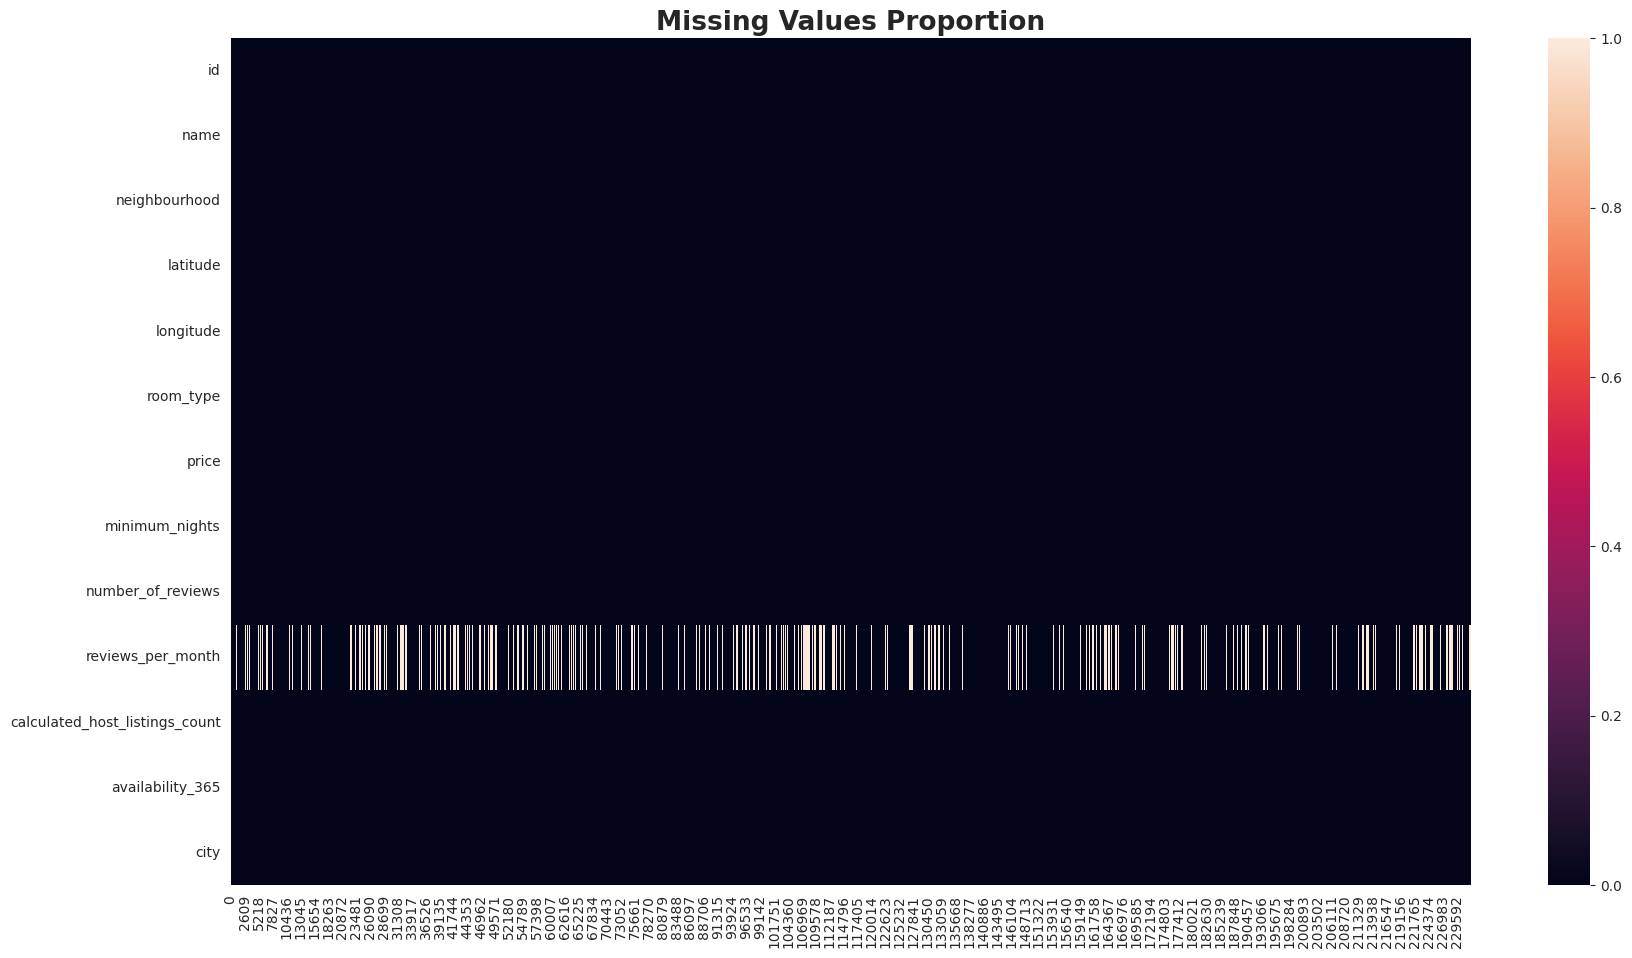

In [ ]:
ax = sns.heatmap(a_data.isna().T)
ax.set_title('Missing Values Proportion',fontsize=19,fontweight='bold')

## Drop missing value

In [ ]:
a_data = a_data.dropna()
missing = a_data.isna().sum()
missing /= a_data.shape[0]
missing *=100
missing = missing.to_frame().rename(columns={0:'Precent Of Missing Values'})
missing

Precent Of Missing Values
id                                                    0.0
name                                                  0.0
neighbourhood                                         0.0
latitude                                              0.0
longitude                                             0.0
room_type                                             0.0
price                                                 0.0
minimum_nights                                        0.0
number_of_reviews                                     0.0
reviews_per_month                                     0.0
calculated_host_listings_count                        0.0
availability_365                                      0.0
city                                                  0.0

## Feature engineering

In [ ]:
states_dic = {'Asheville':'NC','Austin':'TX','Boston':'MA','Broward County':'FL','Cambridge':'MA','Chicago':'IL','Clark County':'NV','Columbus':'OH','Denver':'CO','Hawaii':'HI','Jersey City':'NJ',
             'Los Angeles':'SC','Nashville':'TN','New Orleans':'MS','New York City':'NY','Oakland':'CA','Pacific Grove':'CA','Portland':'OR','Rhode Island':'RI','Salem':'MA','San Clara Country':'CA',
             'Santa Cruz County':'CA','San Diego':'CA','San Francisco':'CA','San Mateo County':'CA','Seattle':'WA','Twin Cities MSA':'MN','Washington D.C.':'DC', 'Santa Clara County': 'CA'}

a_data['state'] = a_data['city'].apply(lambda x : states_dic[x])

In [ ]:
a_data.head()

id                                               name     neighbourhood  \
0   958              Bright, Modern Garden Unit - 1BR/1BTH  Western Addition   
1  5858                                 Creative Sanctuary    Bernal Heights   
2  8142  Friendly Room Apt. Style -UCSF/USF - San Franc...    Haight Ashbury   
3  8339                    Historic Alamo Square Victorian  Western Addition   
4  8739                Mission Sunshine, with Private Bath           Mission   

   latitude  longitude        room_type  price  minimum_nights  \
0  37.77028 -122.43317  Entire home/apt    202               2   
1  37.74474 -122.42089  Entire home/apt    235              30   
2  37.76555 -122.45213     Private room     56              32   
3  37.77564 -122.43642  Entire home/apt    575               9   
4  37.76030 -122.42197     Private room    110               1   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                383               2.31                               1   
1                111               0.66                               1   
2                  9               0.09                              13   
3                 28               0.17                               2   
4                770               4.65                               2   

   availability_365           city state  
0               128  San Francisco    CA  
1               365  San Francisco    CA  
2               365  San Francisco    CA  
3               365  San Francisco    CA  
4               159  San Francisco    CA

## Identify nominal and numerical features

In [ ]:
numeric_features = a_data.select_dtypes(include=['int64','float64']).columns
nominal_features = a_data.select_dtypes(include=['object']).columns
numeric_features=numeric_features.delete(0)
a_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183056 entries, 0 to 232115
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              183056 non-null  int64  
 1   name                            183056 non-null  object 
 2   neighbourhood                   183056 non-null  object 
 3   latitude                        183056 non-null  float64
 4   longitude                       183056 non-null  float64
 5   room_type                       183056 non-null  object 
 6   price                           183056 non-null  int64  
 7   minimum_nights                  183056 non-null  int64  
 8   number_of_reviews               183056 non-null  int64  
 9   reviews_per_month               183056 non-null  float64
 10  calculated_host_listings_count  183056 non-null  int64  
 11  availability_365                183056 non-null  int64  
 12  city                 

In [ ]:
nominal_features

Index(['name', 'neighbourhood', 'room_type', 'city', 'state'], dtype='object')

In [ ]:
nominal_features

Index(['name', 'neighbourhood', 'room_type', 'city', 'state'], dtype='object')

## Numeric Features Distribution Analysis and Outlier handling

### Numeric Features Distribution


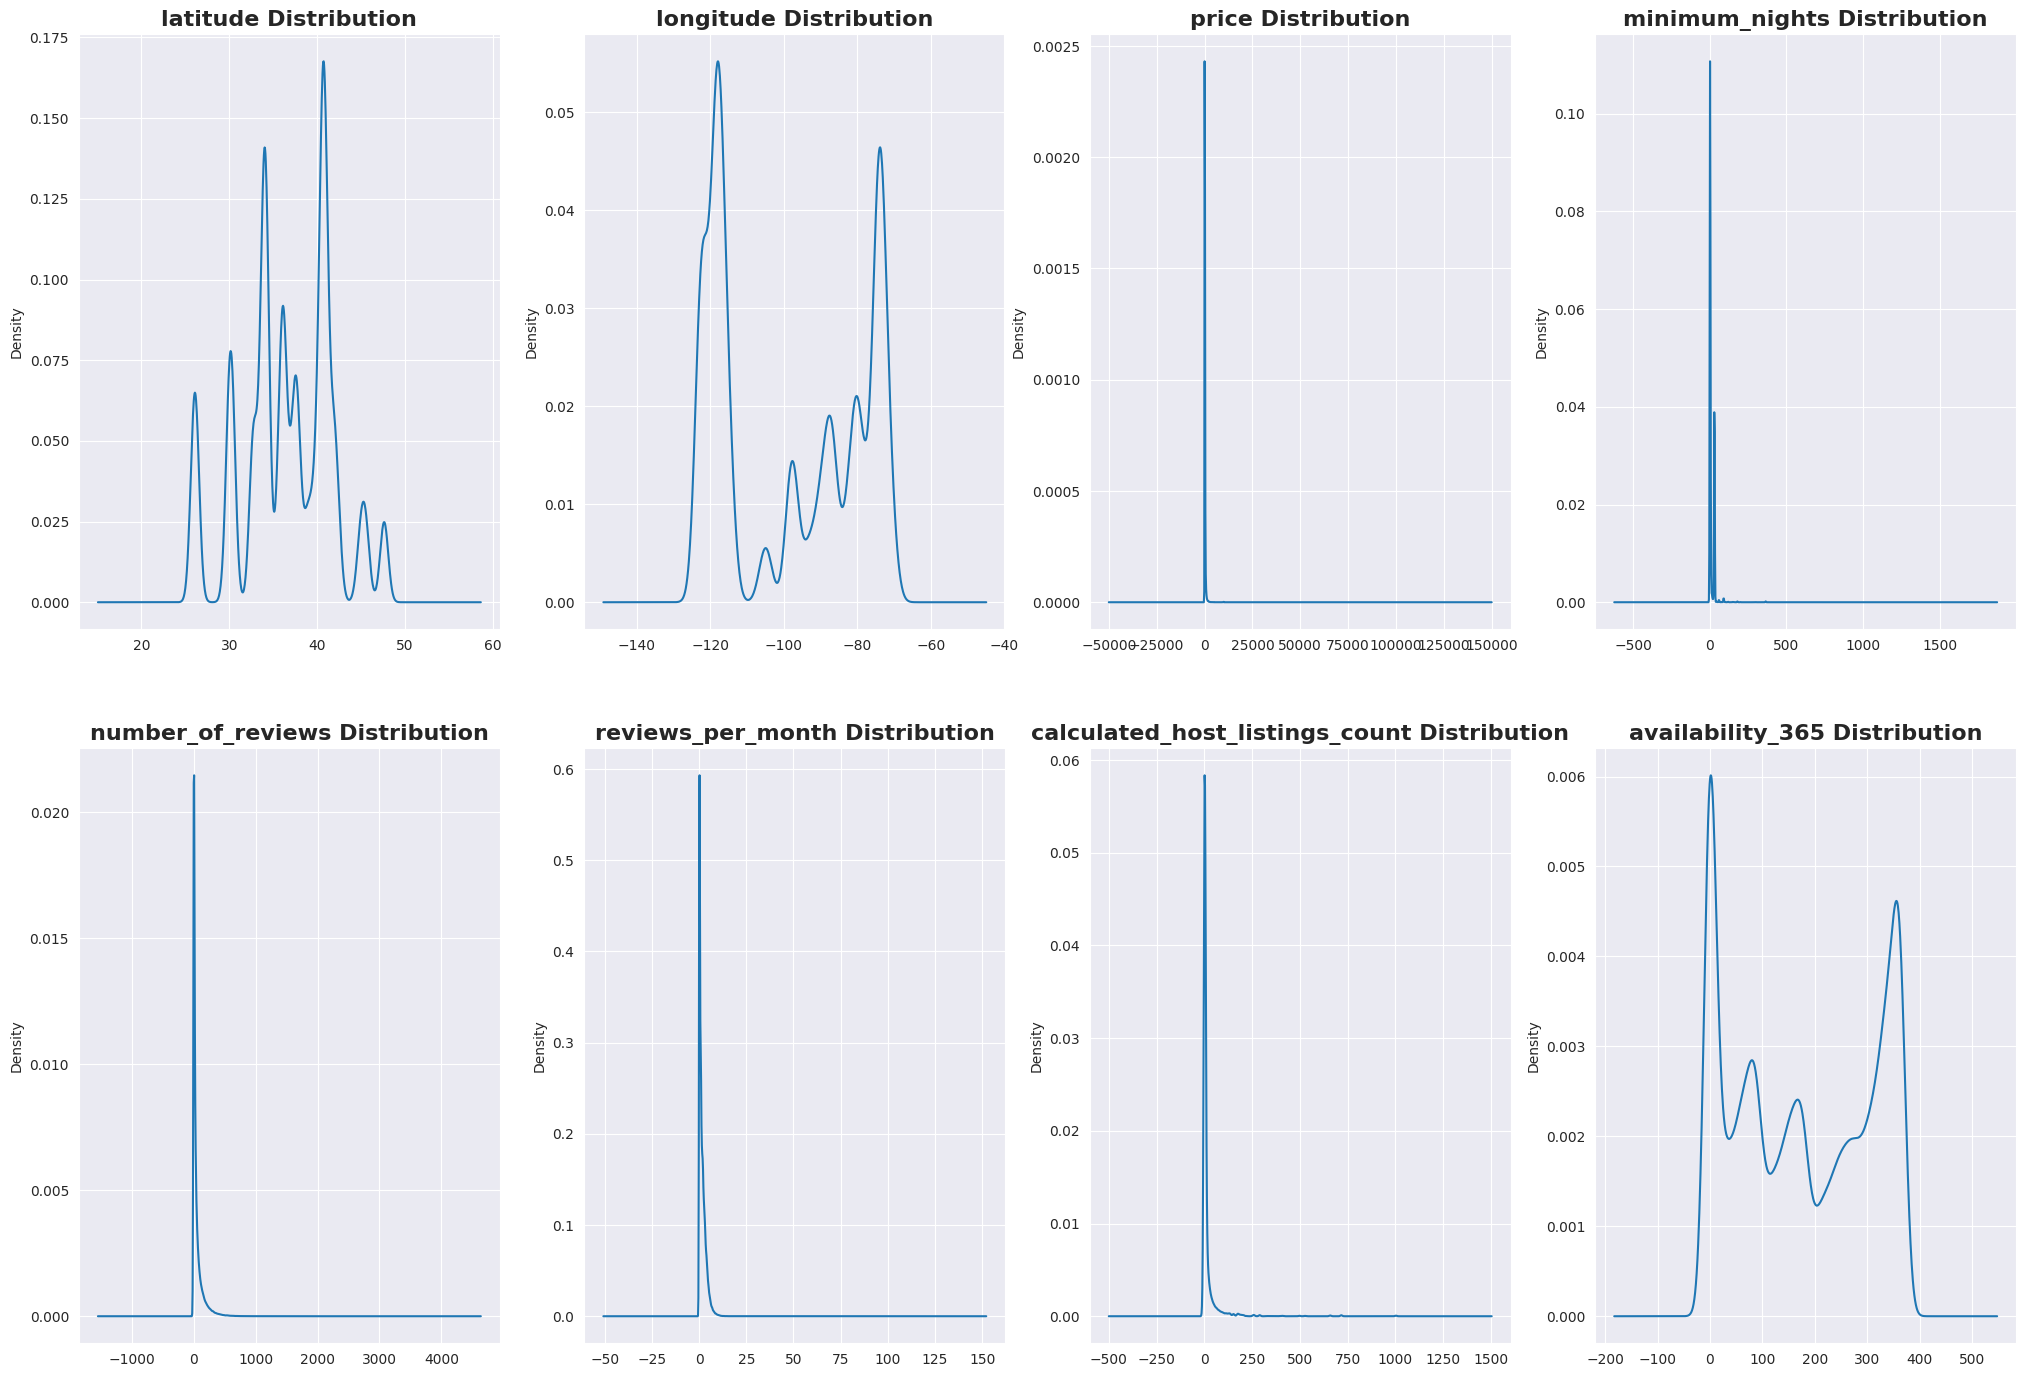

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        a_data[numeric_features[aux]].plot(kind='kde',ax=col)
        col.set_title(numeric_features[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1

### Outlier Removal


In [ ]:
# Removing Outliers !!!
lower_bound = 0.05
upper_bound = 0.95
iqr = a_data[(a_data['price'] >= a_data['price'].quantile(lower_bound)) &
           (a_data['price'] <= a_data['price'].quantile(upper_bound)) &
           (a_data['number_of_reviews'] > 0) &
           (a_data['calculated_host_listings_count'] < 10) &
           (a_data['number_of_reviews'] < 200) &
           (a_data['minimum_nights'] < 10) &
           (a_data['reviews_per_month'] < 5)]

### Processed Distributions After Ourlier Removal


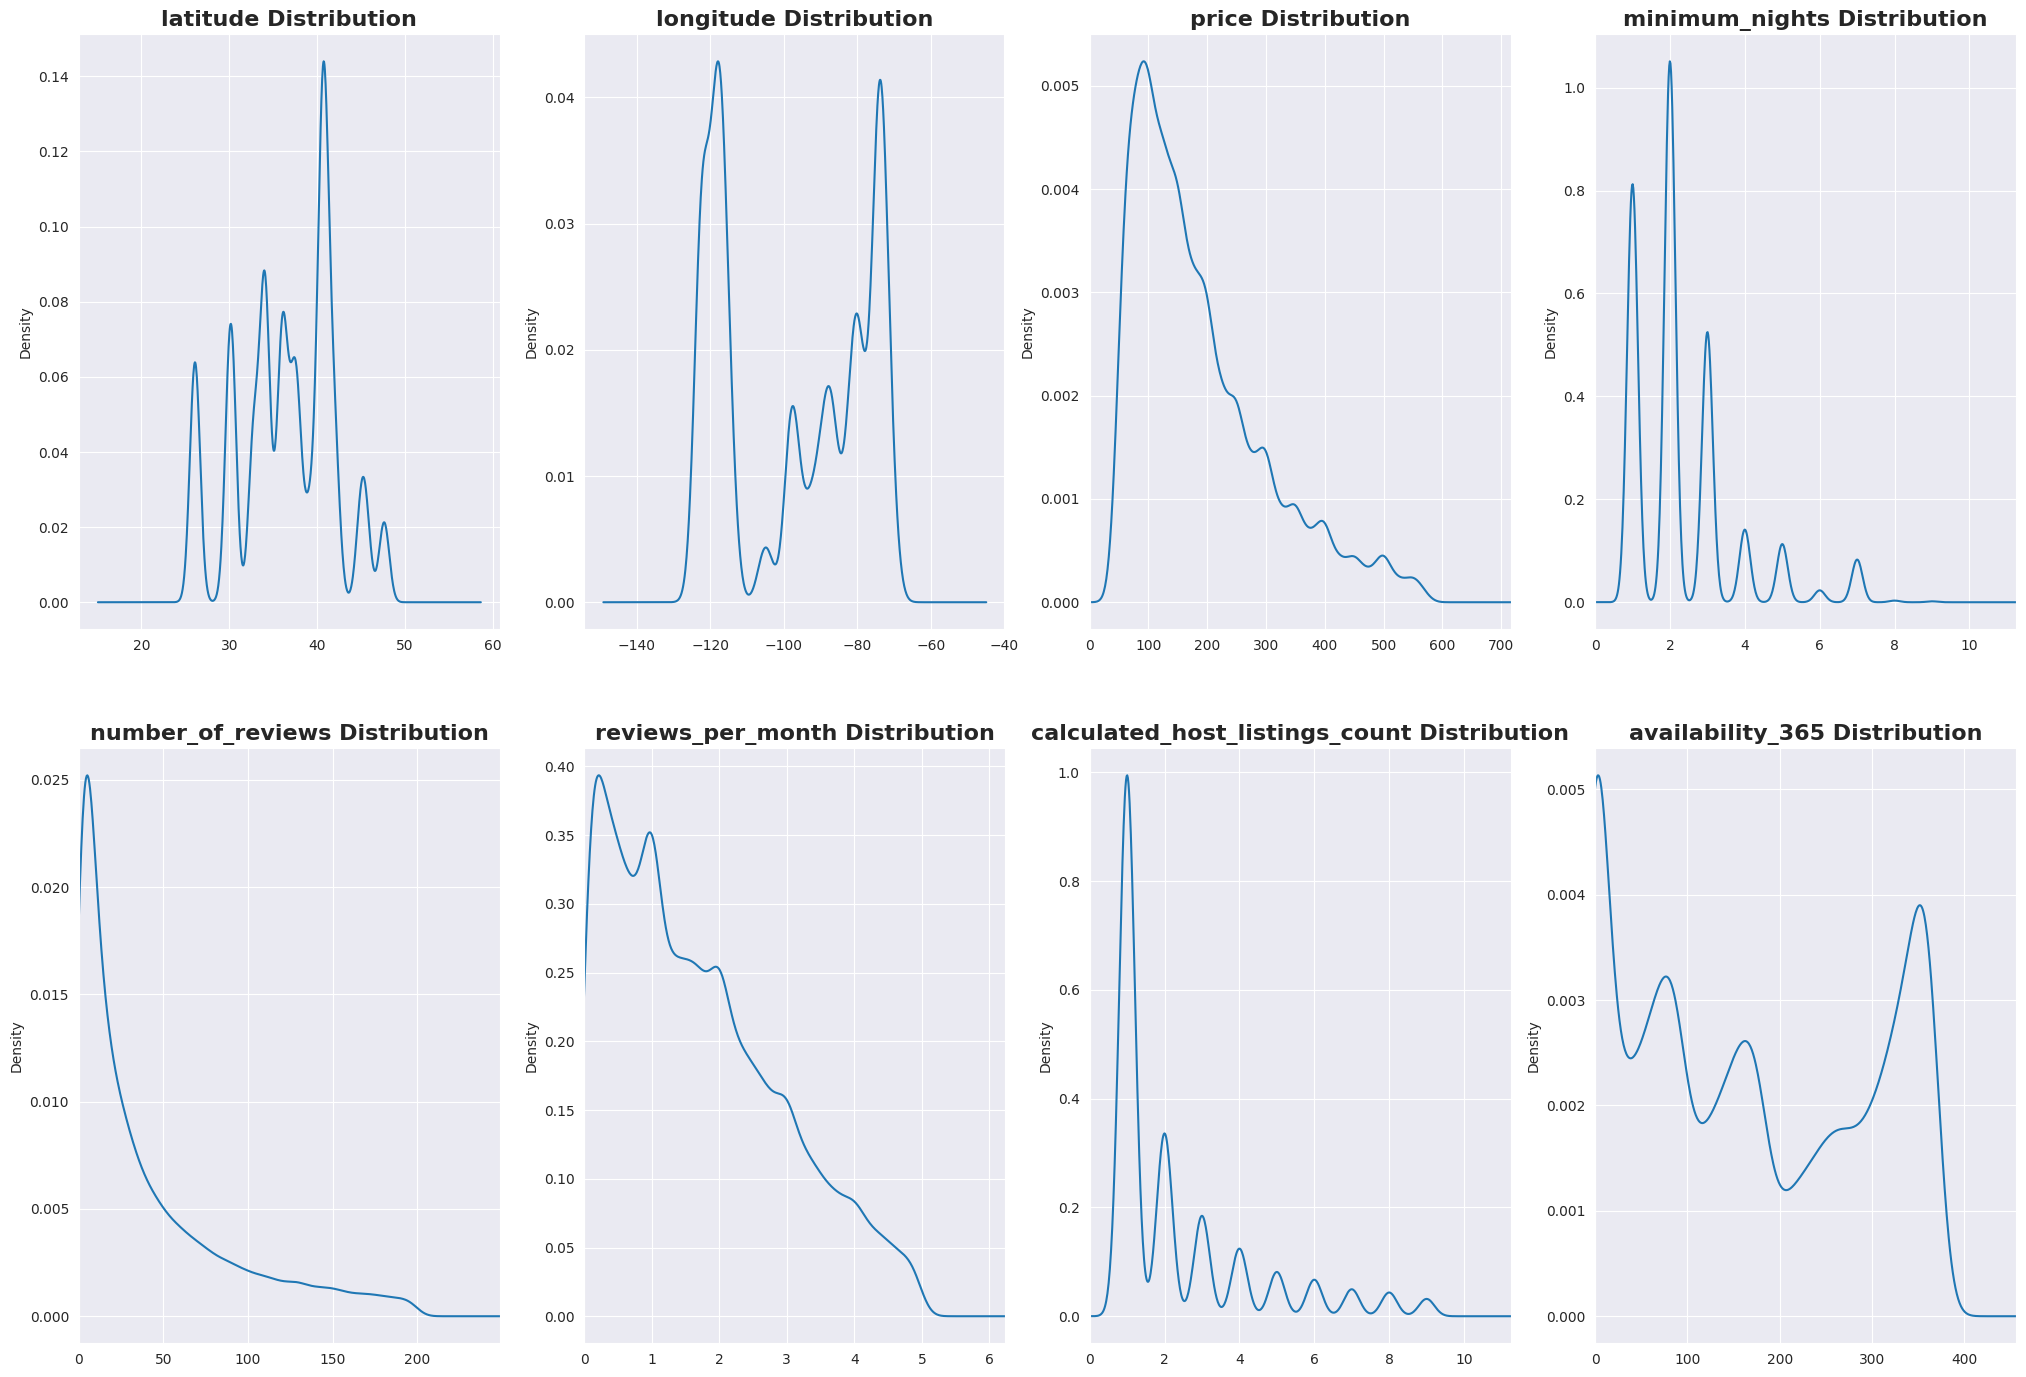

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        iqr[numeric_features[aux]].plot(kind='kde',ax=col)
        if numeric_features[aux] not in ['latitude','longitude']:
            col.set_xlim(0,iqr[numeric_features[aux]].max()+iqr[numeric_features[aux]].max()*0.25)
        col.set_title(numeric_features[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1

<p style="font-family:newtimeroman;font-size:150%;text-align:center">
    So we see that after we removed most of the outliers in our data, we are left we more meaningful distributions from which we can extract some insight.
We can see that the number_of_reveiws feature, as well as the reveiws_pre_month feature, follow an exponential distribution in contrast to all other numeric features in the dataset, which seem to follow a multimodal distribution, which makes sense because there are many underlying groups in our dataset (different location for example)
</p>

In [ ]:
pr_data =iqr.copy()

## Text Cleasing

Download the necessary  utility functions.

In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
pr_data.name = pr_data.name.astype(str)
pr_data.name = pr_data.name.str.lower()

In [ ]:
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))

#choose everyting except alphabetical characters, spaces or tabs.
regex = re.compile('[^a-z\s]')
#substitude non-alphabetical characteres with nothing
pr_data.name = pr_data.name.apply(lambda x: regex.sub('', x))

pr_data['unigrams'] = pr_data['name'].apply(word_tokenize)
#excude words that are in stop_words and its length is less than 3
pr_data['unigrams'] = pr_data['unigrams'].apply(lambda x: [word for word in x
                                            if word not in stopwords and len(word)>2])
pr_data['unigrams']

5         [elegant, cozy, wcity, views, private, room, p...
10                  [central, san, francisco, urban, dream]
13                     [lake, street, single, family, home]
17                      [spacious, brm, breathtaking, view]
27            [iconic, marina, waterfront, walkbike, score]
                                ...                        
232096    [coastal, home, near, beach, hiking, san, fran...
232105         [new, quiet, bungalow, near, stanford, meta]
232107                            [cozy, bedroom, traveler]
232112                        [lovely, bedroom, close, sfo]
232113              [cozy, bedroom, heart, silicon, valley]
Name: unigrams, Length: 80052, dtype: object

## Transformation

In [ ]:
final_data = pr_data.copy()
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80052 entries, 5 to 232113
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              80052 non-null  int64  
 1   name                            80052 non-null  object 
 2   neighbourhood                   80052 non-null  object 
 3   latitude                        80052 non-null  float64
 4   longitude                       80052 non-null  float64
 5   room_type                       80052 non-null  object 
 6   price                           80052 non-null  int64  
 7   minimum_nights                  80052 non-null  int64  
 8   number_of_reviews               80052 non-null  int64  
 9   reviews_per_month               80052 non-null  float64
 10  calculated_host_listings_count  80052 non-null  int64  
 11  availability_365                80052 non-null  int64  
 12  city                            8005

In [ ]:
drop_list = ['id','name','unigrams']
final_data.drop(final_data[drop_list], axis=1, inplace=True)

### Transforming Nominal Data: Label Encoding

In [ ]:
numeric_features = final_data.select_dtypes(include=['int64','float64']).columns
nominal_features = final_data.select_dtypes(include=['object']).columns
numeric_features=numeric_features.delete(0)

In [ ]:
numeric_features

Index(['longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [ ]:
nominal_features

Index(['neighbourhood', 'room_type', 'city', 'state'], dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object for each categorical feature
encoders = {}
for feature in nominal_features:
    encoders[feature] = LabelEncoder()

# Transform the train data
for feature in nominal_features:
    final_data[feature] = encoders[feature].fit_transform(final_data[feature])

### Transforming Numberical Data
1: Normalization on 'number_of_reviews', 'calculated_host_listings_count' columns

2: Standardization on 'longitude', 'minimum_nights', 'reviews_per_month', 'availability_365' columns

In [ ]:
from typing_extensions import final
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Create the scaler objects
normalizer = MinMaxScaler()
standardizer = StandardScaler()

# Transform the data
final_data[['number_of_reviews', 'calculated_host_listings_count']] = normalizer.fit_transform(final_data[['number_of_reviews', 'calculated_host_listings_count']])
final_data[['longitude', 'minimum_nights', 'reviews_per_month', 'availability_365']] = standardizer.fit_transform(final_data[['longitude', 'minimum_nights', 'reviews_per_month', 'availability_365']])

In [ ]:
final_data

neighbourhood   latitude  longitude  room_type  price  minimum_nights  \
5                 125  37.717500  -1.301837          2     95       -0.950461   
10               1336  37.771960  -1.303788          0    425       -0.228634   
13                621  37.785460  -1.305167          0    545        0.493192   
17                913  37.728330  -1.304123          0    235        1.215019   
27                747  37.804890  -1.303927          0    295       -0.228634   
...               ...        ...        ...        ...    ...             ...   
232096            923  37.629639  -1.306641          0    283       -0.950461   
232105            408  37.470786  -1.289029          0    286       -0.950461   
232107           1223  37.631403  -1.302248          2     60       -0.950461   
232112           1223  37.629656  -1.302224          2     52       -0.950461   
232113           1223  37.459521  -1.295059          0     59       -0.950461   

        number_of_reviews  reviews_per_month  calculated_host_listings_count  \
5                0.090909          -1.251574                           0.125   
10               0.277778          -0.992753                           0.000   
13               0.106061          -1.227310                           0.000   
17               0.510101          -0.717755                           0.000   
27               0.555556          -0.644961                           0.000   
...                   ...                ...                             ...   
232096           0.005051           0.269003                           0.000   
232105           0.000000          -0.539815                           0.375   
232107           0.005051           0.269003                           0.375   
232112           0.000000          -0.539815                           0.375   
232113           0.000000          -0.539815                           0.250   

        availability_365  city  state  
5               1.556527    20      0  
10             -1.261059    20      0  
13             -0.812449    20      0  
17              1.454212    20      0  
27             -0.812449    20      0  
...                  ...   ...    ...  
232096          1.485694    21      0  
232105          1.430601    21      0  
232107         -1.111522    21      0  
232112         -1.127263    21      0  
232113          0.667177    21      0  

[80052 rows x 12 columns]

# EDA and Analysis

In [ ]:
points = (pr_data.latitude.fillna(0),pr_data.longitude.fillna(0))
coordinates =[]

# Setting lat and long
lat = points[0]
long = points[1]

# Latitude and longitude that will open map. Here I put New york
mapa = folium.Map(location=[pr_data.latitude.mean(), pr_data.longitude.mean()], zoom_start=3.5)

# Append latitude and longitude coordinates array
for la,lo in zip(lat,long):
    coordinates.append([la,lo])

In [ ]:
from folium import plugins
mapa.add_child(plugins.HeatMap(coordinates))

## Room Type

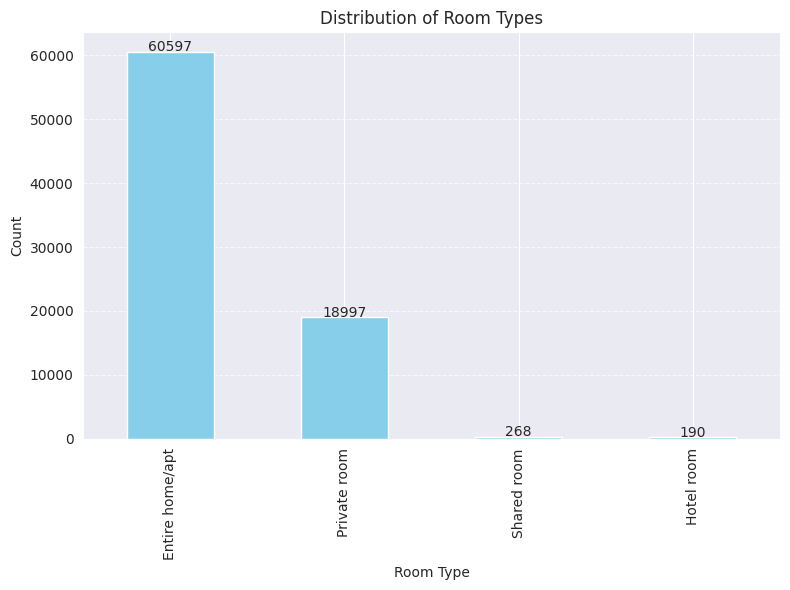

In [ ]:
# Group by room type and count the occurrences
room_type_counts = pr_data['room_type'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
room_type_counts.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.title('Distribution of Room Types')

# Adding annotations
for i, count in enumerate(room_type_counts):
    plt.text(i, count + 100, str(count), ha='center')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

## Comparative Analysis of Room Type Price Distributions Using KDE

This KDE plot illustrates price distributions for different room types. The x-axis represents price range, while the y-axis shows density. "Private room" prices are primarily lower, with a slight right skew. "Entire home/apt" prices vary widely, with higher density in mid-range prices. "Hotel room" prices exhibit a bimodal pattern, indicating two distinct price segments. "Shared room" prices are heavily skewed towards the lower end, featuring a sharp peak and a long tail. These distinct price distribution patterns offer insights into pricing strategies, market segmentation, and customer preferences in the accommodation industry.

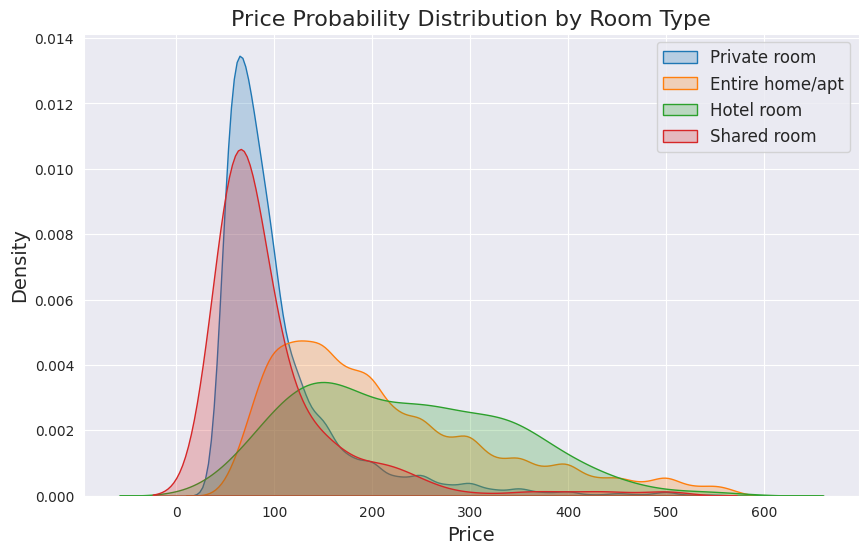

In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the kernel density estimate (KDE) for each room type
for room_type in pr_data['room_type'].unique():
    subset = pr_data[pr_data['room_type'] == room_type]
    sns.kdeplot(subset['price'], fill=True, label=room_type, ax=ax)

# Add labels and title
ax.set_title('Price Probability Distribution by Room Type', fontsize=16)
ax.set_xlabel('Price', fontsize=14)
ax.set_ylabel('Density', fontsize=14)

# Add legend
ax.legend(fontsize=12)

# Show the plot
plt.show()

## Price Distribution Analysis for Top 3 Most Expensive and Bottom 3 Least Expensive Airbnb Cities

The KDE plot shows the price distributions for the top 3 most expensive and bottom 3 least expensive Airbnb cities. The most expensive cities, Pacific Grove, Santa Cruz County, and Rhode Island, display broader distributions with higher price peaks compared to the least expensive cities. The least expensive cities, Portland, Salem, and Columbus, have distributions sharply concentrated around lower price ranges.

Reasons for Higher Prices in Top 3 Cities:

- Pacific Grove: Known for its scenic coastal views, proximity to the Monterey Bay Aquarium, and high-quality accommodations, Pacific Grove commands higher prices due to its tourist appeal and luxury stay options.

- Santa Cruz County: Offers picturesque beaches, a vibrant cultural scene, and popular attractions like the Santa Cruz Beach Boardwalk. The demand for beachfront properties and premium vacation rentals contributes to higher Airbnb prices.

- Rhode Island: Features historic landmarks, beautiful coastal areas, and events such as the Newport Jazz Festival. Its high tourist influx, combined with limited accommodation options in prime locations, drives up prices.

In contrast, Portland, Salem, and Columbus have lower living costs, less tourist traffic, and more competitive accommodation markets, leading to lower Airbnb prices.

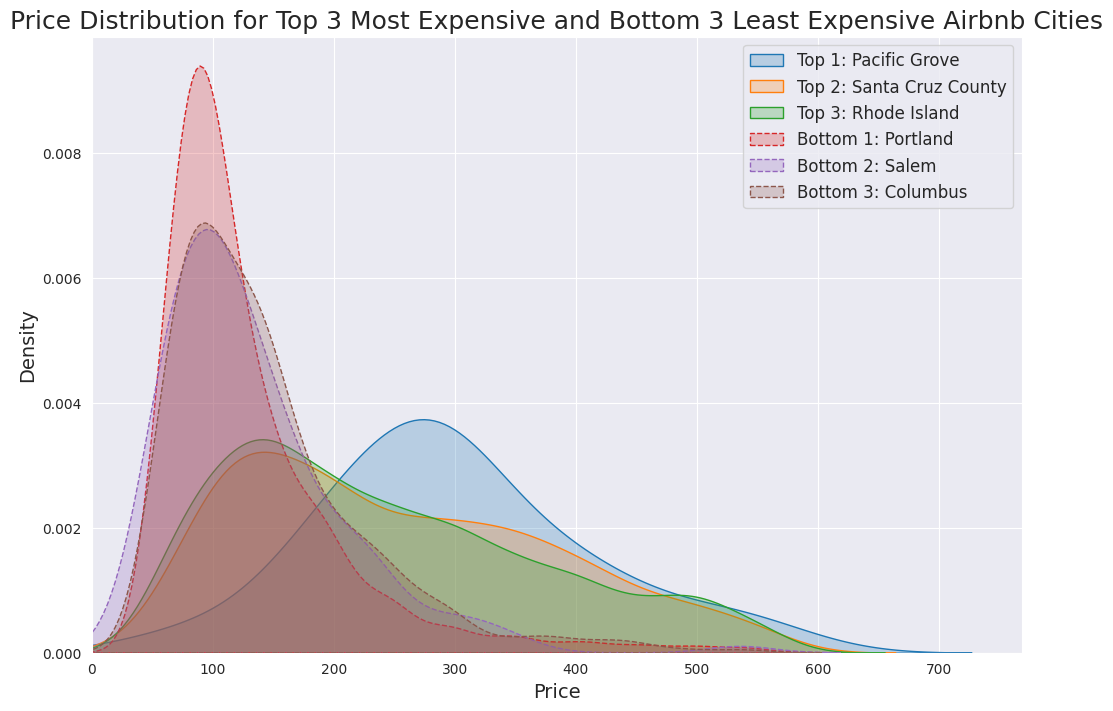

In [ ]:
# Calculate the average price per city
average_prices = pr_data.groupby('city')['price'].mean()

# Get the top 3 most expensive cities
top_expensive_cities = average_prices.sort_values(ascending=False).head(3).index

# Get the bottom 3 least expensive cities
least_expensive_cities = average_prices.sort_values(ascending=True).head(3).index

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the kernel density estimate (KDE) for the top 3 most expensive cities with rank
for rank, city in enumerate(top_expensive_cities, start=1):
    subset = pr_data[pr_data['city'] == city]
    sns.kdeplot(subset['price'], fill=True, label=f'Top {rank}: {city}', ax=ax)

# Plot the kernel density estimate (KDE) for the bottom 3 least expensive cities with rank
for rank, city in enumerate(least_expensive_cities, start=1):
    subset = pr_data[pr_data['city'] == city]
    sns.kdeplot(subset['price'], fill=True, linestyle='--', label=f'Bottom {rank}: {city}', ax=ax)

# Add labels and title
ax.set_title('Price Distribution for Top 3 Most Expensive and Bottom 3 Least Expensive Airbnb Cities', fontsize=18)
ax.set_xlabel('Price', fontsize=14)
ax.set_ylabel('Density', fontsize=14)

# Add legend
ax.legend(fontsize=12)

# Adjust x-axis limits for better visibility
ax.set_xlim(left=0)

# Show the plot
plt.show()


## City And State Based Analysis


This bar chart illustrates the distribution of Airbnb listings across various cities. New York City tops the list with the highest number of listings, followed by Los Angeles and Broward County. These major urban areas are well-known tourist destinations, contributing to the high volume of Airbnb properties.

New York City: A global tourism hub, NYC attracts millions of visitors annually. The demand for short-term rentals is fueled by its iconic landmarks, cultural institutions, and business opportunities.

Los Angeles: Known for its entertainment industry, beaches, and diverse neighborhoods, Los Angeles sees a significant influx of tourists, resulting in a high number of Airbnb listings.

Broward County: Located in Florida, this area includes popular vacation spots like Fort Lauderdale, known for its boating canals and vibrant nightlife.

Austin and San Diego: Both cities are renowned for their cultural scenes, tech industries, and favorable climates, making them attractive for both tourists and business travelers.

Pacific Grove: Despite being at the bottom, this coastal California town is noted for its picturesque views and proximity to attractions like the Monterey Bay Aquarium.

Overall, the distribution reflects the varying demand for short-term rentals, influenced by each city's unique attractions and tourism appeal.

<ipython-input-33-16f3ff953691>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-33-16f3ff953691>:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



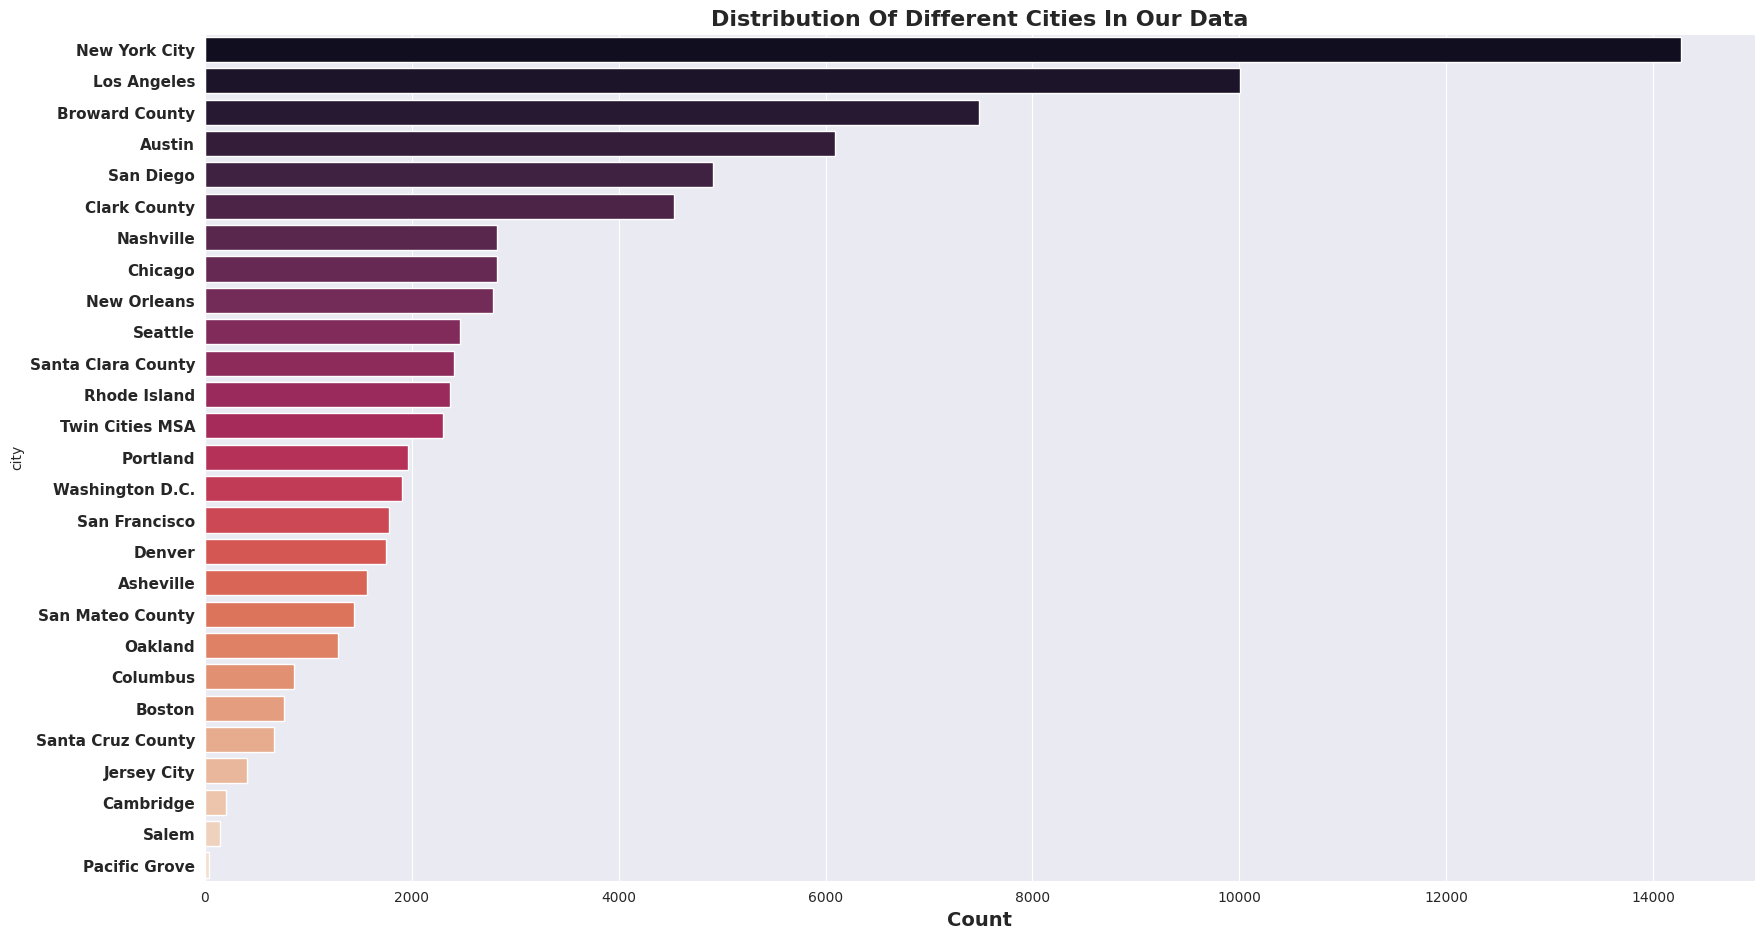

In [ ]:
ax = sns.countplot(y=pr_data['city'],order=pr_data['city'].value_counts().index,palette='rocket')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=11,fontweight='bold')
ax.set_title('Distribution Of Different Cities In Our Data',fontsize=16,fontweight='bold')
ax.set_xlabel('Count',fontsize=14,fontweight='bold')
#ax.set_title()
plt.show()

## Number of Reviews per City

<ipython-input-44-934f7fb048b9>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




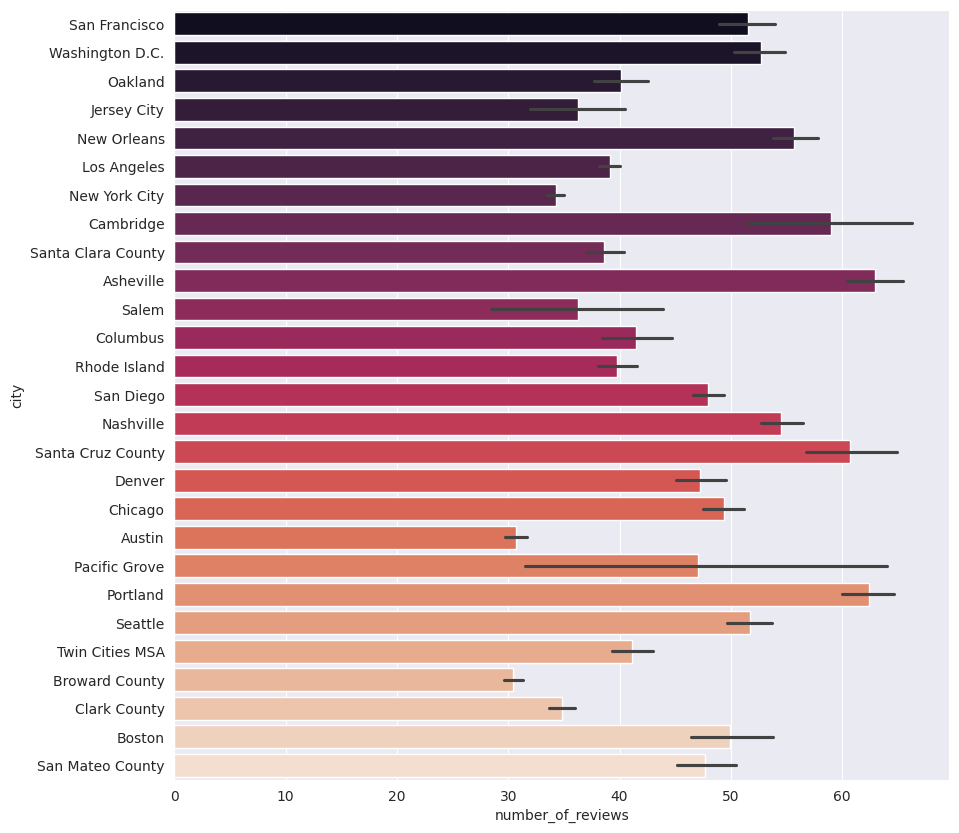

In [ ]:
plt.figure(figsize = (10,10))
box_plot = sns.barplot(x='number_of_reviews', y='city',
                 data=pr_data,
                 palette="rocket")

## Room description Analysis with wordcloud

### Length of Description of Listings


In [ ]:
word_length = pr_data['name'].apply(lambda x : len(str(x).split()))
word_length.describe()

count    80052.000000
mean         6.025508
std          1.916920
min          0.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         44.000000
Name: name, dtype: float64

count    80052.000000
mean         6.025508
std          1.916920
min          0.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         44.000000
Name: name, dtype: float64


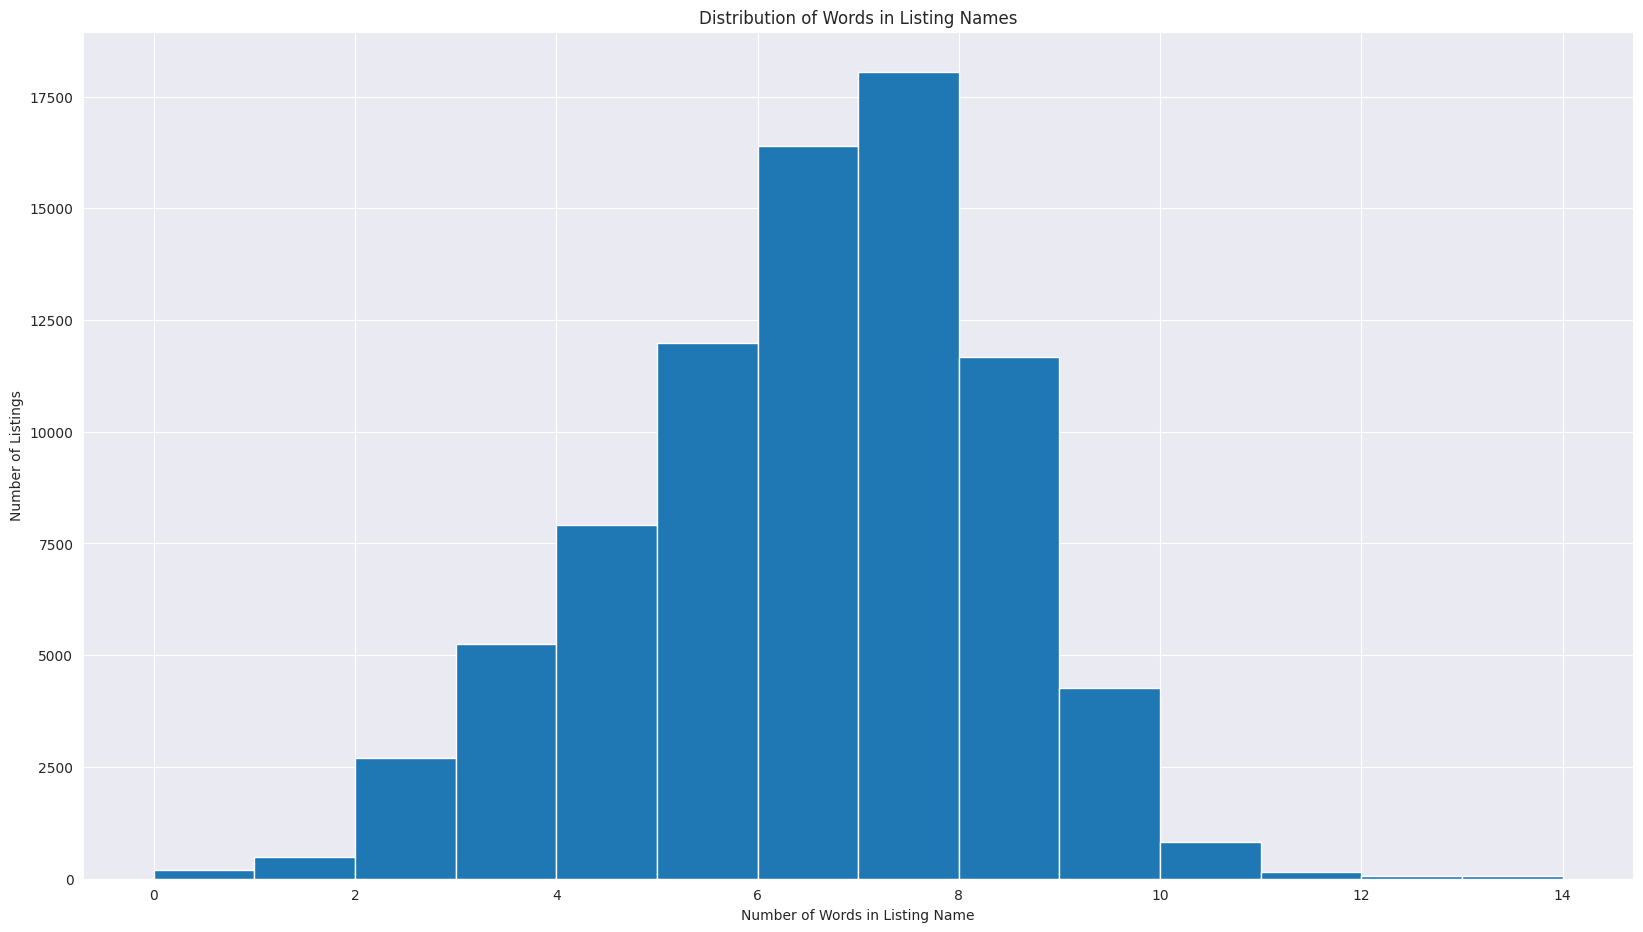

In [ ]:
# Descriptive statistics for word length
print(word_length.describe())

# Create a histogram to visualize word length distribution
plt.hist(word_length,  bins=range(0, 15))
plt.xlabel("Number of Words in Listing Name")
plt.ylabel("Number of Listings")
plt.title("Distribution of Words in Listing Names")
plt.show()

In [ ]:
#count frequency of each word appeard in 'unigrams' column in descending order
count=pd.Series(np.concatenate([x for x in pr_data.unigrams])).value_counts()
count = pd.DataFrame({'unigrams': list(count.keys()),
                   'count': list(count[:])})
#take 30 most frequent words
most_common = count[:10]
most_common

unigrams  count
0    bedroom  10616
1    private  10469
2       home   9920
3       room   7133
4       cozy   6794
5      house   5785
6      beach   5546
7  apartment   5350
8       near   5308
9     modern   4618

### WordCloud

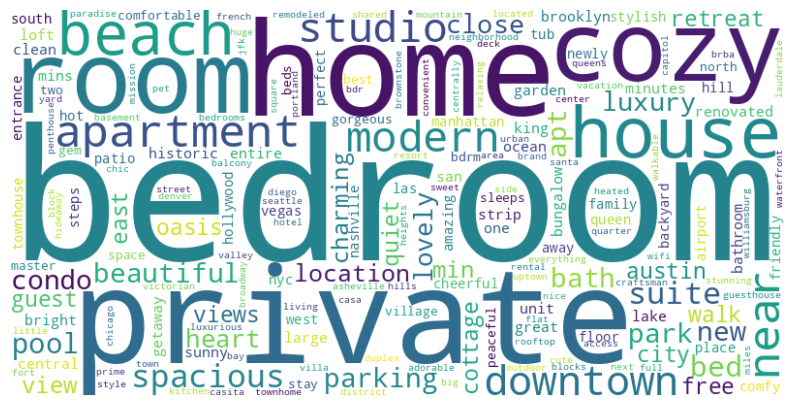

In [ ]:
# Concatenate all the lists of words in the 'unigrams' column
all_words = [word for sublist in pr_data['unigrams'] for word in sublist]

# Create a Series with the word frequencies
word_freq = pd.Series(all_words).value_counts()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Modeling Regression model

## Regression Model

In [ ]:
X = final_data.drop(['price'], axis=1)
y = final_data['price']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Import necessary libraries
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the models
models = [
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('DecisionTreeRegressor', DecisionTreeRegressor()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('GradientBoostingRegressor', GradientBoostingRegressor())
]

# Define the hyperparameter grids for each model
param_grids = [
    {'alpha': np.logspace(-4, 4, 9)},  # Ridge and Lasso
    {'alpha': np.logspace(-4, 4, 9)},  # Ridge and Lasso
    {'max_depth': [2, 4, 6, 8, 10, None], 'min_samples_split': [2, 5, 10]},  # DecisionTreeRegressor
    {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]},  # RandomForestRegressor
    {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.5]},  # GradientBoostingRegressor
]

# Perform hyperparameter tuning using GridSearchCV
best_models = []
for model_name, model in models:
    if model_name == 'Lasso':
        param_grid = param_grids[models.index((model.__class__.__name__, model))]
        param_grid = {'alpha': param_grid['alpha']}  # Remove 'l1_ratio' from Lasso grid
    else:
        param_grid = param_grids[models.index((model.__class__.__name__, model))]

    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models.append((model_name, grid_search.best_estimator_))

# Evaluate the best models using cross-validation
for model_name, model in best_models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f'{model_name} RMSE: {-1 * np.mean(scores):.3f} +/- {np.std(scores):.3f}')

# Select the best model based on the cross-validation scores
best_model = sorted(best_models, key=lambda x: np.mean(cross_val_score(x[1],
                    X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)))[-1][1]

# Fit the best model on the entire training data
best_model.fit(X_train, y_train)

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Best Model Test RMSE: {test_rmse:.3f}')

Ridge RMSE: 101.135 +/- 1.154
Lasso RMSE: 101.135 +/- 1.154
DecisionTreeRegressor RMSE: 97.551 +/- 1.127
RandomForestRegressor RMSE: 91.265 +/- 0.835
GradientBoostingRegressor RMSE: 90.764 +/- 0.854
Best Model Test RMSE: 89.999


In [ ]:
# import joblib

# # Save the best model's weights
# joblib.dump(best_model, 'best_model_weights.pkl')

import joblib

# Save model weights for each model type
for model_name, model in best_models:
    # Define a unique filename based on the model type
    filename = f'{model_name}_weights.pkl'

    # Save the model weights
    joblib.dump(model, filename)


In [ ]:
best_models

[('Ridge', Ridge(alpha=10.0)),
 ('Lasso', Lasso(alpha=0.0001)),
 ('DecisionTreeRegressor',
  DecisionTreeRegressor(max_depth=8, min_samples_split=10)),
 ('RandomForestRegressor', RandomForestRegressor(n_estimators=300)),
 ('GradientBoostingRegressor',
  GradientBoostingRegressor(max_depth=7, n_estimators=300))]

### GradientBoostingRegressor result (Best Model)  

GradientBoostingRegressor Model Test RMSE: 89.999


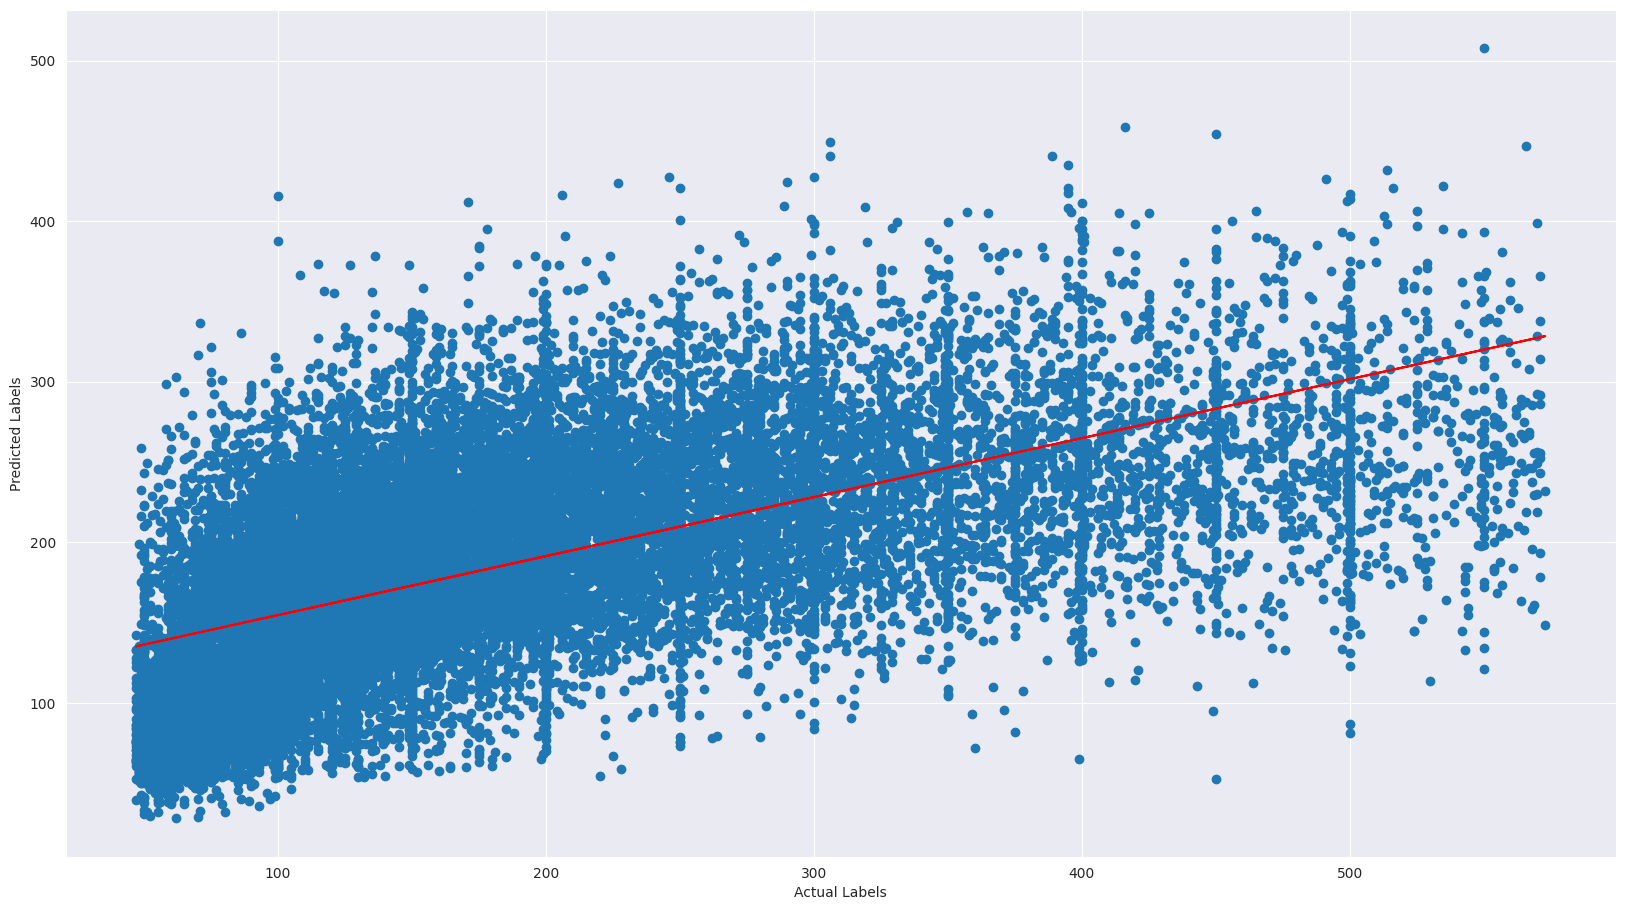

In [ ]:
# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'GradientBoostingRegressor Model Test RMSE: {test_rmse:.3f}')

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')
plt.show()